<h3> <strong> 1. 실험 </strong> </h3>

utils 폴더에 있는 augmentations.py의 transform 구성을 아래로 바꾸고 학습시켜 봤다.

```
self.transform = A.Compose([
                A.OneOf([
                    A.Flip(p=1.0),
                    A.RandomRotate90(p=1.0)
                ]),
                A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.15, p=0.5),
                A.GaussNoise(p=0.2),
                A.OneOf([
                    A.Blur(p=1.0),
                    A.GaussianBlur(p=1.0),
                    A.MedianBlur(blur_limit=5, p=1.0),
                    A.MotionBlur(p=1.0)
                ], p=0.1),
                A.CLAHE(p=0.01)],  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)
```

* 학습 명령: python train.py --img 1024 --batch 8 --epochs 70 --data './data/dataset.yaml' --cfg './models/yolov5x.yaml' --weights yolov5x.pt --hyp './runs/evolve/YoloV5x_Hyp_tuning/hyp_evolve.yaml' --label-smoothing 0.1 --name YoloV5x_augmentation --cache

* 테스트 명령: python detect.py --img 1024 --source './data/test' --weights './runs/train/YoloV5x_augmentation/weights/best.pt' --save-txt --save-conf --name YoloV5x_augmentation --augment

* Pseudo labeling을 위한 테스트 명령: python detect.py --img 1024 --source './data/test' --weights './runs/train/YoloV5x_augmentation/weights/best.pt' --save-txt --name Labeling_YoloV5x_augmentation --augment --iou-thres 0.5

아래는 Pseudo labeling을 위해 labeling된 이미지들을 저장하고 label들을 저장하는 코드이다.

In [3]:
if not os.path.exists('./images_and_labels'): os.makedirs('./images_and_labels')                # images, labels 파일을 담을 파일 
if not os.path.exists('./images_and_labels/images'): os.makedirs('./images_and_labels/images')  # train, test 이미지를 저장할 파일, train 이미지는 미리 옮겨놔야 한다.
if not os.path.exists('./images_and_labels/labels'): os.makedirs('./images_and_labels/labels')  # train, test의 라벨을 저장할 파일

In [4]:
import json
import os

with open("../detection/dataset/train.json", "r") as json_file: # label이 저장된 train.json 파일을 가져온다.
    train_json = json.load(json_file)

ann_index = 0; img_index = 0                                    # 탐색할 annotation, image에 대한 인덱스이다. image의 인덱스란 이미지의 번호를 의미한다. (0100의 경우 100이다.)
txt_path = './images_and_labels/labels'

while img_index < 4883:                                         # BBox가 저장된 모든 annotation을 탐색한다.
    image_id = str(img_index)                                   # 이미지 번호를 형식에 맞게 저장한다. (0은 '0000', 1은 '0001' 식으로 변경)
    while len(image_id)<4: image_id = '0'+image_id
    txt_file = open(os.path.join(txt_path, image_id+'.txt'), 'w')

    string = ''
    while ann_index < len(train_json['annotations']):
        annotation = train_json['annotations'][ann_index]
        if img_index != annotation['image_id']:                 # 현재 탐색하고 있는 이미지와 id가 일치하는지 확인하고 일치하지 않으면 반복문을 탈출한다. 
            break                       
        
        category = annotation['category_id']                    # category_id(class number)를 가져온다.
        coco_x, coco_y, coco_w, coco_h = annotation['bbox']     # bbox를 가져온다. (coco dataset)
        yolo_x = (coco_x+coco_w/2)/1024                         # yolo dataset 형식으로 바꿔준다.
        yolo_y = (coco_y+coco_h/2)/1024
        yolo_w = coco_w/1024
        yolo_h = coco_h/1024
        
        string += f'{category} {yolo_x:.6} {yolo_y:.6} {yolo_w:.6} {yolo_h:.6}\n'
        ann_index += 1
    txt_file.write(string.rstrip())
    txt_file.close()
    img_index += 1

In [6]:
import os

label_path = '../yolov5/runs/detect/Labeling_YoloV5x_augmentation/labels'   # 라벨이 존재하는 폴더를 지정한다.
save_path = './images_and_labels/labels'                                    # 라벨을 저장할 폴더를 지정한다.

image_id = 4883                                                             # 위에서 train image들을 저장할 때 마지막 image의 id가 4882이므로 test이미지를 저장할 때는 4883으로 시작해야 한다.
for test_idx in range(4871):
    test_id = str(test_idx)
    while len(test_id)<4: test_id = '0'+test_id 
    try:
        txt_file = open(os.path.join(label_path, test_id+'.txt'), 'r')      # 라벨을 가져온다.
        lines = txt_file.readlines()
        txt_file.close()

        save_id = str(image_id)
        txt_file = open(os.path.join(save_path, save_id+'.txt'), 'w')
        txt_file.write(''.join(lines))
        txt_file.close()

        image_id += 1
    except:
        pass

In [7]:
import numpy as np
import os
from PIL import Image

imgs_path = './../detection/dataset/test'                                   # 이미지 파일에 접근하기 위해 train_image가 저장된 path를 지정해 놓는다.
label_path = '../yolov5/runs/detect/Labeling_YoloV5x_augmentation/labels'   # 라벨이 존재하는 폴더를 지정한다.
save_path = './images_and_labels/images'                                    # 이미지를 저장할 폴더를 지정한다.
image_id = 4883                                                             # 위에서 train image들을 저장할 때 마지막 image의 id가 4882이므로 test이미지를 저장할 때는 4883으로 시작해야 한다.

for test_idx in range(4871):
    test_id = str(test_idx)
    while len(test_id)<4: test_id = '0'+test_id 

    if not os.path.exists(os.path.join(label_path, test_id+'.txt')): continue

    save_id = str(image_id)
    img = Image.open(os.path.join(imgs_path, test_id+'.jpg'))               # 이미지를 가져오고 저장한다.
    img.save(os.path.join(save_path, save_id+'.jpg'), 'JPEG') 
    image_id += 1
    
print('Complete Download Test Images')

Complete Download Test Images


가져온 이미지들과 기존의 train 이미지들을 train과 valid 셋으로 나누는 코드이다.

In [8]:
if not os.path.exists('./train'): os.makedirs('./train')                # train images, labels 파일을 담을 파일
if not os.path.exists('./train/images'): os.makedirs('./train/images')  
if not os.path.exists('./train/labels'): os.makedirs('./train/labels')  
if not os.path.exists('./valid'): os.makedirs('./valid')                # valid images, labels 파일을 담을 파일
if not os.path.exists('./valid/images'): os.makedirs('./valid/images')  
if not os.path.exists('./valid/labels'): os.makedirs('./valid/labels')  

In [11]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from PIL import Image

imgs = [str(i) for i in range(9738)]                            # 이미지들에 접근하기 위해 형태에 맞게 이미지 번호를 저장한다. (index->0~9753)
for i in range(len(imgs)):
    while len(imgs[i])<4: imgs[i] = '0'+imgs[i] 

np.random.seed(777)                                             # random seed를 고정한다.
np.random.shuffle(imgs)                                         # 이미지 번호를 섞어준다.

train_imgs, valid_imgs = train_test_split(imgs, test_size=0.2)  # random seed는 위에서 지정했으므로 지정하지 않아도 된다.
train_imgs.sort()                                               
valid_imgs.sort()

imgs_path = './images_and_labels/images'                        # 이미지 파일에 접근하기 image가 저장된 path를 지정해 놓는다.

print(f'train imgs 개수: {len(train_imgs)} / valid imgs 개수: {len(valid_imgs)}')

for train_img in train_imgs:
    save_path = './train/images'                                # 이미지를 저장할 폴더를 지정한다.
    if not os.path.exists(save_path): os.makedirs(save_path)    # 해당 폴더가 없으면 생성한다.
    img = Image.open(os.path.join(imgs_path, train_img+'.jpg')) # 이미지를 가져오고 저장한다.
    img.save(os.path.join(save_path, train_img+'.jpg'), 'JPEG') 

print('Complete Download Train Images')
    
for valid_img in valid_imgs:
    save_path = './valid/images'                                # 이미지를 저장할 폴더를 지정한다.
    if not os.path.exists(save_path): os.makedirs(save_path)    # 해당 폴더가 없으면 생성한다.
    img = Image.open(os.path.join(imgs_path, valid_img+'.jpg')) # 이미지를 가져오고 저장한다.
    img.save(os.path.join(save_path, valid_img+'.jpg'), 'JPEG')
    
print('Complete Download Valid Images')

train imgs 개수: 7790 / valid imgs 개수: 1948
Complete Download Train Images
Complete Download Valid Images


In [12]:
import shutil

labels_path = './images_and_labels/labels'                         

for train_img in train_imgs:
    save_path = './train/labels'                                    
    if not os.path.exists(save_path): os.makedirs(save_path)        
    shutil.copy(os.path.join(labels_path, train_img+'.txt'), save_path)     

print('Complete Download Train Labels')
    
for valid_img in valid_imgs:
    save_path = './valid/labels'                                    
    if not os.path.exists(save_path): os.makedirs(save_path)        
    shutil.copy(os.path.join(labels_path, valid_img+'.txt'), save_path)  
    
print('Complete Download Valid Labels')

Complete Download Train Labels
Complete Download Valid Labels


기존 train, test셋에 소속된 이미지가 거의 비슷한 비율로 나눠진 것을 확인할 수 있다.

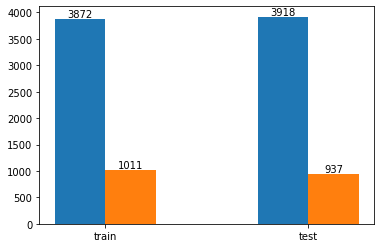

In [28]:
import numpy as np
import matplotlib.pyplot as plt

train_class = [0, 0]
for train_img in train_imgs:
    if int(train_img)<4883: train_class[0]+=1
    else: train_class[1]+=1

valid_class = [0, 0]
for valid_img in valid_imgs:
    if int(valid_img)<4883: valid_class[0]+=1
    else: valid_class[1]+=1

index = np.array([0, 1])
width = 0.25
train = plt.bar(index-0.5*width, train_class, width=width)
valid = plt.bar(index+0.5*width, valid_class, width=width)

for rect in train:
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2.0, height, str(height), ha='center', va='bottom', size=10)
for rect in valid:
    height = rect.get_height()
    plt.text(rect.get_x()+rect.get_width()/2.0, height, str(height), ha='center', va='bottom', size=10)


plt.xticks(index, ['train', 'test'])

plt.show()

* 학습 명령: python train.py --img 1024 --batch 8 --epochs 70 --data './data/labeling_dataset.yaml' --cfg './models/yolov5x.yaml' --weights yolov5x.pt --hyp './runs/evolve/YoloV5x_Hyp_tuning/hyp_evolve.yaml' --label-smoothing 0.1 --name YoloV5x_augmentation_labeling --cache

* 테스트: python detect.py --img 1024 --source './data/test' --weights './runs/train/YoloV5x_augmentation_labeling/weights/best.pt' --augment --save-txt --save-conf --name YoloV5x_augmentation_labeling

In [9]:
import pandas as pd
import os

df = pd.DataFrame(index=[i for i in range(4871)], columns=['PredictionString', 'image_id'])
yolo_path = './../yolov5/runs/detect/YoloV5x_augmentation/labels'
for img_index in range(4871):
    image_id = str(img_index)
    while len(image_id)<4: image_id = '0'+image_id

    PredictionString = ''
    try: 
        txt_file = open(os.path.join(yolo_path, image_id+'.txt'), 'r')
        lines = txt_file.readlines()
    
        for line in lines:
            category, yolo_x, yolo_y, yolo_w, yolo_h, pred = (line.split())
            x_min = (float(yolo_x)-float(yolo_w)/2)*1024
            y_min = (float(yolo_y)-float(yolo_h)/2)*1024
            x_max = x_min+float(yolo_w)*1024
            y_max = y_min+float(yolo_h)*1024
            PredictionString += f'{category} {pred} {x_min} {y_min} {x_max} {y_max} '
        txt_file.close()
    except FileNotFoundError:
        pass
    
    df.iloc[img_index] = [PredictionString, 'test/'+image_id+'.jpg']

df.to_csv('./YoloV5x_augmentation.csv', index=False)

<h3> <strong> 2. 결과 </strong> </h3> 

(1) Pseudo Labeling 미적용: 0.5312 / TTA를 적용했던 0.5017보다 성능이 향상됨. <br>
(2) Pseudo Labeling 적용: 0.5249 / labeling을 만든 모델이 아니라 기존 yolov5x pre-trained 모델의 weight를 가져오 학습 시켰더니 오히려 성능이 떨어짐.